In [1]:
using Plots
using Printf
using Statistics

In [2]:
N_avogadro = 6.022136736e23  #Avogadro"s number
k = 1.38065812e-23  #Boltzman thermodynamic constant
Rstar = 1000. * k * N_avogadro  #Universal gas constant
G = 6.67430e-11

6.6743e-11

In [3]:
# scale constants
MRef = MEarth = 5.972e24
rRef = rEarth = 6.371e6
rhoRef = MRef / ((4 * pi / 3) * rRef^3)
pRef = (3 / (4 * pi)) * MRef^2 * G / (rRef ^ 4)

3.449262859761734e11

In [4]:
# Van Der Waals coefficients, for units of bars, and moles/litre
#    (From Wikipedia data page)
aH2O, bH2O = 5.536, 0.03049
aCO2, bCO2 = 3.640, 0.04267
aH2, bH2 = 0.2476, 0.02661
aH2S, bH2S = 4.490, 0.04287
aSO2, bSO2 = 6.803, 0.05636
aN2, bN2 = 1.370, 0.0387
aCH4, bCH4 = 2.253, 0.04278

(2.253, 0.04278)

In [143]:
# example
list_of_species_dicts = [Dict("formula"=>"H2O", "a"=> aH2O, "b"=> bH2O, "M"=> 18., "mass_mixing_ratio"=> 0.2),
                         Dict("formula"=>"H2",  "a"=> aH2,  "b"=> bH2,  "M"=> 2. , "mass_mixing_ratio"=> 0.3),
                         Dict("formula"=>"CH4",  "a"=> aCH4,  "b"=> bCH4,  "M"=> 16. , "mass_mixing_ratio"=> 0.5)
                         ]

3-element Vector{Dict{String, Any}}:
 Dict("M" => 18.0, "mass_mixing_ratio" => 0.2, "formula" => "H2O", "b" => 0.03049, "a" => 5.536)
 Dict("M" => 2.0, "mass_mixing_ratio" => 0.3, "formula" => "H2", "b" => 0.02661, "a" => 0.2476)
 Dict("M" => 16.0, "mass_mixing_ratio" => 0.5, "formula" => "CH4", "b" => 0.04278, "a" => 2.253)

In [144]:
function EOSVDW(rho, p, T, R, a, b)
    """ # Van Der Waals EOS
    returns 0, where rho = 1/v """
    return (p + a * rho ^ 2) * (1. / rho - b) - R * T
end

EOSVDW (generic function with 1 method)

In [145]:
function rhoVDW(p, T, R, a, b)
    # I solved this using sympy because it's awful
    rho = -(b ^ (-2) - 3 * (b * p + R * T) / (a * b)) / (3 * (sqrt(
        -4 * (b ^ (-2) - 3 * (b * p + R * T) / (a * b)) ^ 3 + (
                    -2 / b ^ 3 - 27 * p / (a * b) + 9 * (b * p + R * T) / (
                        a * b ^ 2)) ^ 2) / 2 - 1 / b ^ 3 - 27 * p / (2 * a * b) + 9 * (b * p + R * T) / (
                                                                           2 * a * b ^ 2)) ^ (1 / 3)) - (sqrt(
        -4 * (b ^ (-2) - 3 * (b * p + R * T) / (a * b)) ^ 3 + (
                    -2 / b ^ 3 - 27 * p / (a * b) + 9 * (b * p + R * T) / (
                        a * b ^ 2)) ^ 2) / 2 - 1 / b ^ 3 - 27 * p / (2 * a * b) + 9 * (b * p + R * T) / (
                                                                                                                       2 * a * b ^ 2)) ^ (
                      1 / 3) / 3 + 1 / (3 * b)
    return rho
end

rhoVDW (generic function with 1 method)

In [146]:
function rhoAmagat(p, T, list_of_species_dicts)
    """density from additive volume law, 1/rho = sum_i(1/rho_i)
    rho function needs to take pressure"""

    # solve each density individually
    rho_part = zeros(length(list_of_species_dicts))
    mass_mixing_ratios = zeros(length(list_of_species_dicts))
    for (ii, species) in enumerate(list_of_species_dicts)
        R = Rstar / species["M"]  # individual gas constant
        a = species["a"]
        b = species["b"]
        rho_part[ii] = rhoVDW(p, T, R, a, b)
        mass_mixing_ratios[ii] = species["mass_mixing_ratio"]
    end

    # additive volumes, assumes ideal mixing
    rho_part_inv = 1 ./ rho_part[:]
    rho_tot_inv = sum(mass_mixing_ratios[:] .* rho_part_inv[:])
    rho = 1 / rho_tot_inv
    return rho
end

rhoAmagat (generic function with 1 method)

In [147]:
function get_mmw(vmr_dict, mw_dict)
    mws = 0.0
    for k in keys(vmr_dict)
        mws += mw_dict[k]*vmr_dict[k]
    end
    return mws
end

get_mmw (generic function with 1 method)

In [148]:
function rhoIDEAL(p, T, R)
    return p / (T*R)
end

rhoIDEAL (generic function with 1 method)

In [149]:
p = 1.0
T = 100.0
mu = 18.0
@printf("%.2e\n",rhoVDW(p, T, Rstar/mu, aH2, bH2))
@printf("%.2e\n",rhoIDEAL(p, T, Rstar/mu))

2.16e-05
2.16e-05


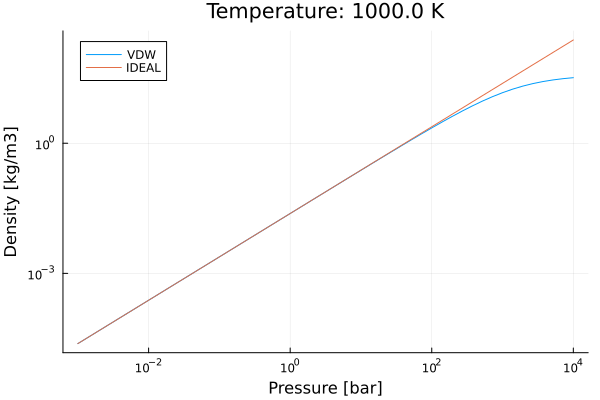

In [150]:
p = 1e5 * 300
T = 1000.0
mu = 2.0

fig = plot(yscale=:log10, ylabel="Density [kg/m3]",
            xscale=:log10, xlabel="Pressure [bar]", legend=:topleft,
            title=@sprintf("Temperature: %.1f K", T))

p_arr = collect(Float64, range(-3, 4, length=50))
p_arr[:] .= 10.0 .^ (p_arr[:] .+ 5)
plot!(fig, p_arr./1e5, rhoVDW.(p_arr[:], T, Rstar/mu, aH2, bH2), label="VDW")
plot!(fig, p_arr./1e5, rhoIDEAL.(p_arr[:], T, Rstar/mu), label="IDEAL")

display(fig)

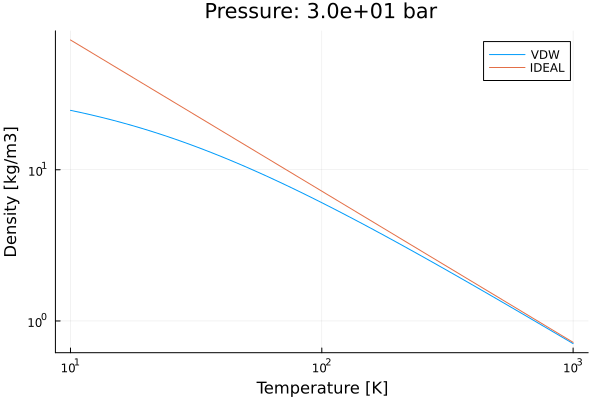

In [151]:
p = 1e5 * 30
mu = 2.0
t_arr = collect(Float64, range(1, 3, length=50))
t_arr[:] .= 10.0 .^ t_arr[:]

fig = plot(yscale=:log10, ylabel="Density [kg/m3]",
            xscale=:log10, xlabel="Temperature [K]",
            title=@sprintf("Pressure: %.1e bar", p/1e5))

plot!(fig, t_arr, rhoVDW.(p, t_arr[:], Rstar/mu, aH2, bH2), label="VDW")
plot!(fig, t_arr, rhoIDEAL.(p, t_arr[:], Rstar/mu), label="IDEAL")

display(fig)

In [152]:
p = 1e5 * 1.0
T = 3000.0

@printf("%.2e \n",rhoAmagat(p, T, list_of_species_dicts))
# display(list_of_species_dicts)

2.08e-02 
